# Universal Inverse Problem Demo - grayscale images

## important: run this on GPU !!!!!!!!!!!

In [1]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *
import argparse
from torch.autograd import Variable

%matplotlib inline

## load denoiser

#### you can add your universal denoiser of choice to the denoisers folder and try the algorithm on that. 
#### Here we use the default universal denoiser, BF-CNN. 

In [3]:
class gamma(nn.Module):
    '''Returns a gamma vector for each layer'''
    def __init__(self, num_kernels):
        super(gamma, self).__init__()
        self.num_kernels = num_kernels
        self.weight = nn.Parameter(torch.ones(self.num_kernels), requires_grad=True)
        self.weight.data.normal_(mean=0, std=np.sqrt(2./9./64.)).clamp_(-0.025,0.025)
    def forward(self, x):
        return  self.weight.view(1,self.num_kernels,1,1).expand_as(x)



class Net(nn.Module):

    def __init__(self, all_params):
        super(Net, self).__init__()

        self.padding_mid = all_params['padding_mid']
        self.num_mid_kernels = all_params['num_mid_kernels']
        self.kernel_size_mid = all_params['kernel_size_mid']
        self.num_mid_layers = all_params['num_mid_layers']

        self.conv_layers = nn.ModuleList([])
        self.gammas = nn.ModuleList([])
        self.running_sd = []

        self.conv_layers.append(nn.Conv2d(1,self.num_mid_kernels, self.kernel_size_mid, padding=self.padding_mid , bias=False))

        for l in range(1,self.num_mid_layers-1):
            self.conv_layers.append(nn.Conv2d(self.num_mid_kernels ,self.num_mid_kernels, self.kernel_size_mid, padding=self.padding_mid , bias=False))
            self.gammas.append(gamma(self.num_mid_kernels))
            self.running_sd.append(0)

        self.conv_layers.append(nn.Conv2d(self.num_mid_kernels,1, self.kernel_size_mid, padding=self.padding_mid , bias=False))


    def forward(self, x):

        ## pass through the denoising function/network

        relu = nn.ReLU(inplace=True)
        x = relu(self.conv_layers[0](x))
        for l in range(1,self.num_mid_layers-1):
            x = self.conv_layers[l](x)

            sd_x = torch.sqrt(x.permute(1,0,2,3).contiguous().view(self.num_mid_kernels,-1).var(unbiased = False, dim = 1) + 1e-05)

            if self.conv_layers[l].training:
                x = x / (sd_x.view(1,self.num_mid_kernels,1,1).expand_as(x))
                x = x *  self.gammas[l-1](x)
                self.running_sd[l-1] = (1-.1) * self.running_sd[l-1] + .1 * sd_x.data
            else:
                x = x / Variable(self.running_sd[l-1].view(1,self.num_mid_kernels,1,1).expand_as(x), requires_grad=False)
                x = x *  self.gammas[l-1](x)

            x = relu(x)

        x = self.conv_layers[-1](x)

        return x

#######################



all_params = {
'epochs': 50,
"learning_rate" : .001,
'parent_included': 'not applicable',
'kernel_size_waves': 'not applicable',

"kernel_size_mid" : 3,
"padding_mid" : 1,
"num_mid_kernels" : 64,
"num_mid_layers" : 20,

"batch_size" : 128,
"patch_size" : (50,50),
"patching_strides" : (10,10),
'scales' : [1,.9,.8,.7],
}

model = Net(all_params)
if torch.cuda.is_available():
    model = model.cuda()


noise_level_range = [0,100]
all_params['dir_name'] = 'denoisers/BF_CNN_grayscale/noise_range_' + str(noise_level_range[0])+'to'+ str(noise_level_range[1])


best_model = all_params['dir_name']+'/model.pt'
if torch.cuda.is_available():
    learned_params =torch.load(best_model)
    running_sd = torch.load(all_params['dir_name']+'/running_sd.pt')

else:
    learned_params =torch.load(best_model, map_location='cpu' )
    running_sd = torch.load(all_params['dir_name']+'/running_sd.pt', map_location='cpu')


model.load_state_dict(learned_params)
for i in range(all_params['num_mid_layers']-2):
    model.running_sd[i] = running_sd[i]
model.eval();


# Synthesis


----------------------------- 5
sigma  0.8778620958328247
----------------------------- 10
sigma  0.6121803522109985
----------------------------- 15
sigma  0.3274579644203186
----------------------------- 20
sigma  0.13454848527908325
----------------------------- 25
sigma  0.038330234587192535
----------------------------- 30
sigma  0.009453920647501945
-------- total number of iterations,  31
-------- average time per iteration (s),  0.0559
value range 0 255


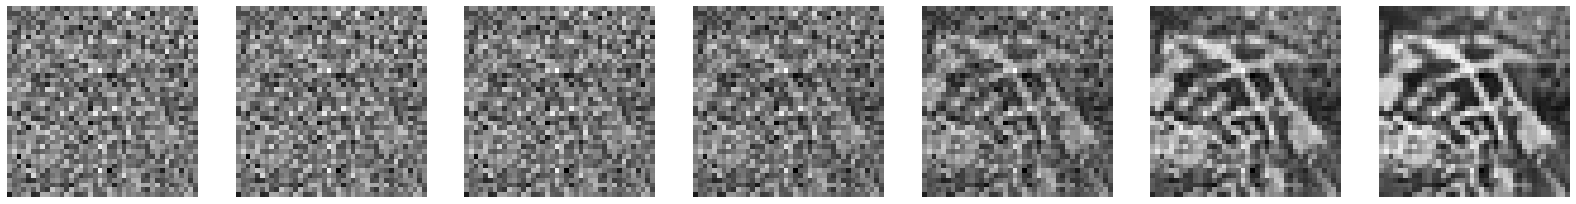

In [80]:
freq =5
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((1,40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = 1,          
                                    save_interm=True)

## plot the progression and the final sample


plot_synthesis(intermed_Ys, sample)

----------------------------- 8
sigma  0.8488484621047974
----------------------------- 16
sigma  0.53837651014328
----------------------------- 24
sigma  0.2632046639919281
----------------------------- 32
sigma  0.09748926758766174
----------------------------- 40
sigma  0.021668778732419014
-------- total number of iterations,  44
-------- average time per iteration (s),  0.0524
value range 0 255


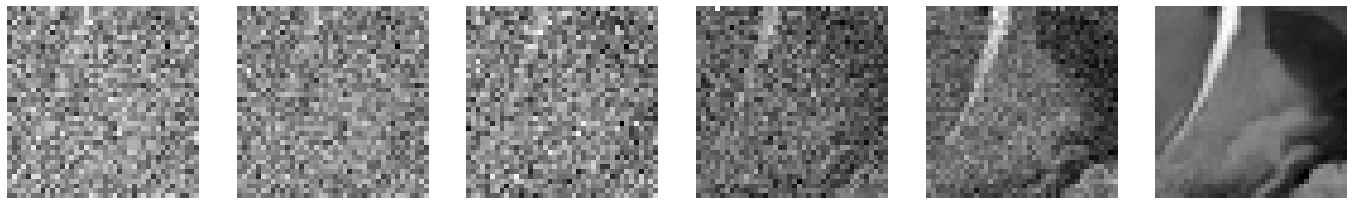

In [99]:
freq =8
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((1,40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = .5,          
                                    save_interm=True)

## plot the progression and the final sample

plot_synthesis(intermed_Ys, sample)

In [5]:
freq = 5
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(np.zeros((40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = 1,          
                                    save_interm=True)



----------------------------- 5
sigma  0.8885794511197128
----------------------------- 10
sigma  0.6301354403250667
----------------------------- 15
sigma  0.3492349167651264
----------------------------- 20
sigma  0.1496692714694182
----------------------------- 25
sigma  0.04949536044777631
----------------------------- 30
sigma  0.009869001237551942
-------- total number of iterations,  31
-------- average time per iteration (s),  0.0647


# Inverse probems

## load a test image


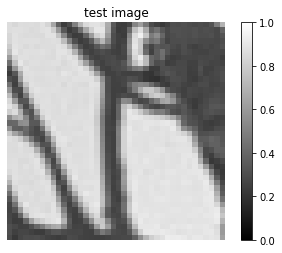

In [141]:
test_folder_path = 'test_images/grayscale/Set68/'

x = single_image_loader(test_folder_path,39)
x = x[:,100:140,100:140] # crop a patch

if x.dtype == torch.uint8: 
    x = x/255

plt.imshow(x[0], 'gray', vmin=0, vmax = 1)
plt.title('test image')
plt.colorbar()
plt.axis('off');


## 1. Inpainting

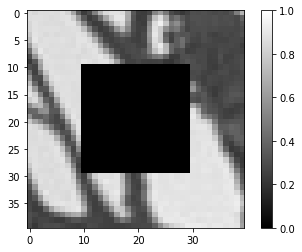

In [112]:
inpaint = inpainting(x.shape, 20,20)

plt.imshow(inpaint.M(inpaint.M_T(x))[0], 'gray', vmin=0, vmax = 1)
plt.colorbar()

----------------------------- 20
sigma  0.9642453193664551
----------------------------- 40
sigma  0.8492686152458191
----------------------------- 60
sigma  0.7211207151412964
----------------------------- 80
sigma  0.6164666414260864
----------------------------- 100
sigma  0.5051102638244629
----------------------------- 120
sigma  0.413972944021225
----------------------------- 140
sigma  0.32342129945755005
----------------------------- 160
sigma  0.223735049366951
----------------------------- 180
sigma  0.15932901203632355
----------------------------- 200
sigma  0.1237645298242569
----------------------------- 220
sigma  0.07380811870098114
----------------------------- 240
sigma  0.03924451768398285
----------------------------- 260
sigma  0.0187546256929636
-------- total number of iterations,  269
-------- average time per iteration (s),  0.0607


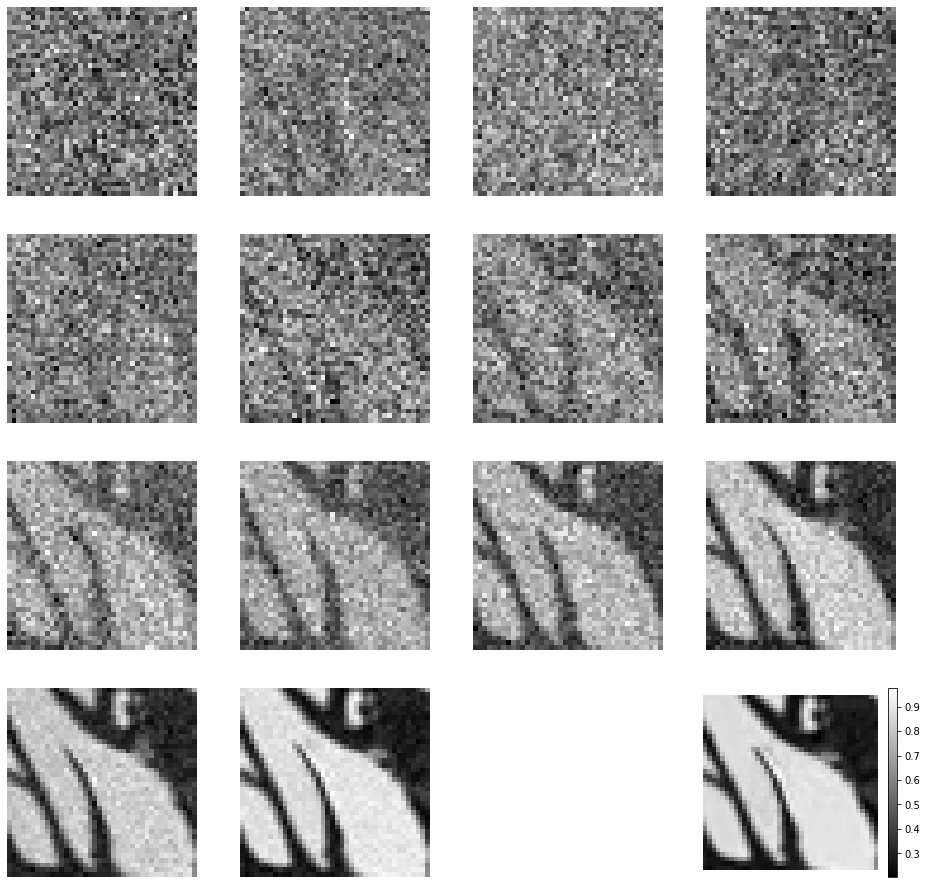

In [129]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= inpaint.M_T(x), 
                                    M_T= inpaint.M_T,
                                    M = inpaint.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=True)
plot_all_samples(sample, intermed_Ys)

## 2. random pixel drop

----------------------------- 20
sigma  0.9148379564285278
----------------------------- 40
sigma  0.8536661267280579
----------------------------- 60
sigma  0.7800551652908325
----------------------------- 80
sigma  0.5792574882507324
----------------------------- 100
sigma  0.4129539430141449
----------------------------- 120
sigma  0.24759173393249512
----------------------------- 140
sigma  0.1272754967212677
----------------------------- 160
sigma  0.04922804981470108
-------- total number of iterations,  180
-------- average time per iteration (s),  0.059


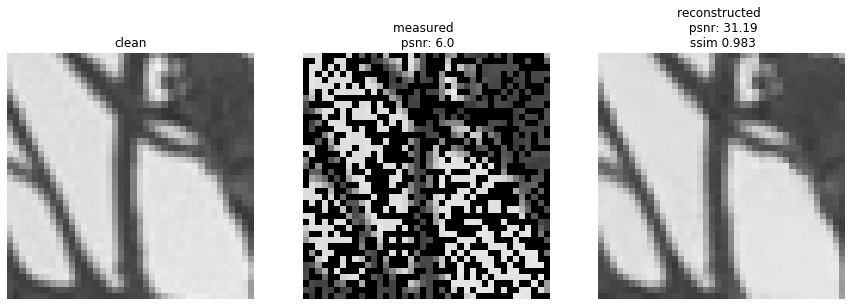

In [154]:
rand_pix = rand_pixels(x.size(), .5)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_pix.M_T(x), 
                                    M_T= rand_pix.M_T,
                                    M = rand_pix.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=False)
## plot
plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. super resolution 


----------------------------- 20
sigma  1.0200960636138916
----------------------------- 40
sigma  0.9207966923713684
----------------------------- 60
sigma  0.8826162219047546
----------------------------- 80
sigma  0.7305226922035217
----------------------------- 100
sigma  0.5793541669845581
----------------------------- 120
sigma  0.3893972933292389
----------------------------- 140
sigma  0.30880215764045715
----------------------------- 160
sigma  0.18233327567577362
----------------------------- 180
sigma  0.08842118084430695
-------- total number of iterations,  197
-------- average time per iteration (s),  0.0588


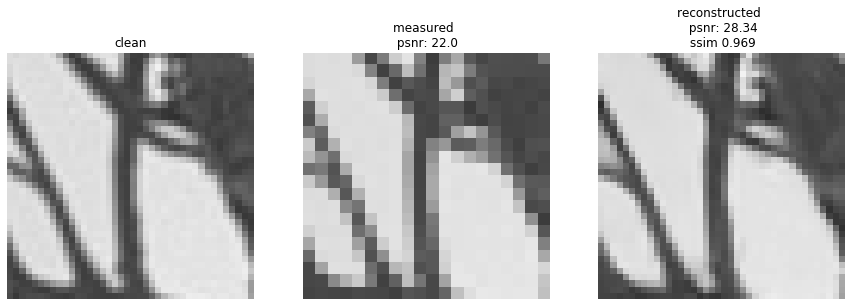

In [156]:

super_res = super_resolution(x.size(), 2)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.03, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.001,          
                                    save_interm=False)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

## 4. Random basis

----------------------------- 20
sigma  0.9995263814926147
----------------------------- 40
sigma  0.8937214016914368
----------------------------- 60
sigma  0.7507678270339966
----------------------------- 80
sigma  0.4952404499053955
----------------------------- 100
sigma  0.33178141713142395
----------------------------- 120
sigma  0.17380452156066895
----------------------------- 140
sigma  0.07202519476413727
-------- total number of iterations,  159
-------- average time per iteration (s),  0.0657


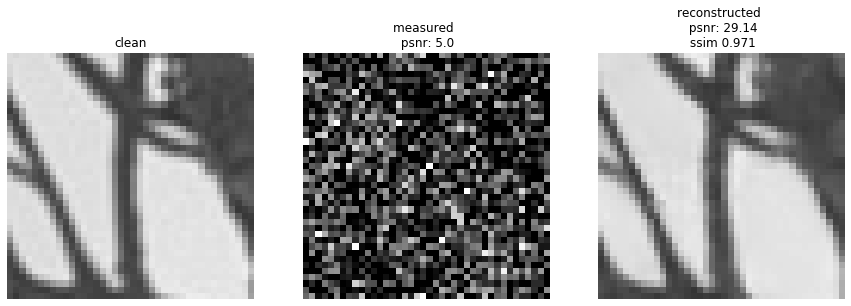

In [158]:
rand_basis = random_basis(x.shape , .3)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_basis.M_T(x), 
                                    M_T= rand_basis.M_T,
                                    M = rand_basis.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=False)
# plot
plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

## 5. spectural super resolution

----------------------------- 20
sigma  0.9464003443717957
----------------------------- 40
sigma  0.7662736177444458
----------------------------- 60
sigma  0.648597240447998
----------------------------- 80
sigma  0.39200299978256226
----------------------------- 100
sigma  0.27446550130844116
----------------------------- 120
sigma  0.1256941854953766
----------------------------- 140
sigma  0.011617504991590977
-------- total number of iterations,  142
-------- average time per iteration (s),  0.0345


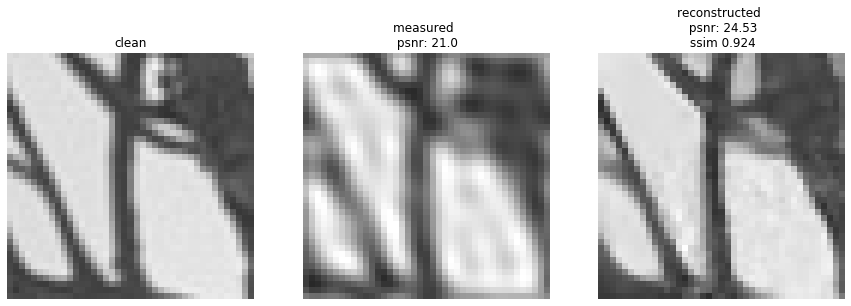

In [155]:
x = single_image_loader(test_folder_path, 39)[:, 100:141, 100:141]
spec_super_res = spectral_super_resolution( x_size=(x.shape[1], x.shape[2]), p = .34)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=spec_super_res.M_T(x), 
                                    M_T= spec_super_res.M_T,
                                    M = spec_super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=True)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)